In [39]:
# 1. Montage du Drive pour ne pas perdre les données
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import pandas as pd
import glob

# On ajuste la liste à 8 colonnes comme indiqué par l'erreur
cols_8 = [
    'timestamp', 'missing', 'job_id', 'event_type',
    'user', 'scheduling_class', 'priority', 'resource_req'
]

# Les colonnes dont vous avez besoin pour le projet
useful_cols = ['timestamp', 'job_id', 'event_type']

files = glob.glob("/content/drive/MyDrive/raw/2011/part-*.csv.gz")
df_list = []

for f in files:
    try:
        # On utilise les 8 colonnes détectées
        temp_df = pd.read_csv(f,
                              compression='gzip',
                              names=cols_8,
                              usecols=useful_cols)
        df_list.append(temp_df)
        print(f"Fichier chargé avec succès : {f}")
    except Exception as e:
        print(f"Erreur sur le fichier {f}: {e}")



df_jobs = pd.concat(df_list)



len(df_jobs)




Fichier chargé avec succès : /content/drive/MyDrive/raw/2011/part-00485-of-00500.csv.gz
Fichier chargé avec succès : /content/drive/MyDrive/raw/2011/part-00234-of-00500.csv.gz
Fichier chargé avec succès : /content/drive/MyDrive/raw/2011/part-00301-of-00500.csv.gz
Fichier chargé avec succès : /content/drive/MyDrive/raw/2011/part-00440-of-00500.csv.gz
Fichier chargé avec succès : /content/drive/MyDrive/raw/2011/part-00111-of-00500.csv.gz
Fichier chargé avec succès : /content/drive/MyDrive/raw/2011/part-00051-of-00500.csv.gz
Fichier chargé avec succès : /content/drive/MyDrive/raw/2011/part-00210-of-00500.csv.gz
Fichier chargé avec succès : /content/drive/MyDrive/raw/2011/part-00108-of-00500.csv.gz
Fichier chargé avec succès : /content/drive/MyDrive/raw/2011/part-00362-of-00500.csv.gz
Fichier chargé avec succès : /content/drive/MyDrive/raw/2011/part-00407-of-00500.csv.gz
Fichier chargé avec succès : /content/drive/MyDrive/raw/2011/part-00346-of-00500.csv.gz
Fichier chargé avec succès : /co

2012242

In [46]:


# Charger un échantillon du premier fichier
print("Chargement d'un échantillon (10,000 lignes)...")


print(f"\n✅ Chargé: {len(df_jobs):,} lignes")
print(f"\nColonnes: {df_jobs.columns.tolist()}")
print(f"\nTypes de données:")
print(df_jobs.dtypes)



Streaming output truncated to the last 5000 lines.
179    1048297131254  6354182144           4        3494
180    1048304452278  6354229930           4        3494
181    1048312033607  6353345435           4        3494
182    1048312033642  6353345597           5        3494
183    1048317189840  6354114267           4        3494
184    1048317189866  6354114436           5        3494
185    1048321255793  6354229156           4        3494
186    1048326027147  6354226716           4        3494
187    1048332079684  6354107363           4        3494
188    1048342614476  6354123211           4        3494
189    1048342614544  6354123406           5        3494
190    1048342614549  6354123546           5        3494
191    1048344755431  6354217798           4        3494
192    1048344755722  6354217877           5        3494
193    1048344755727  6354218435           5        3494
194    1048348842057  6354231340           0        3494
195    1048348853391  6354231574     

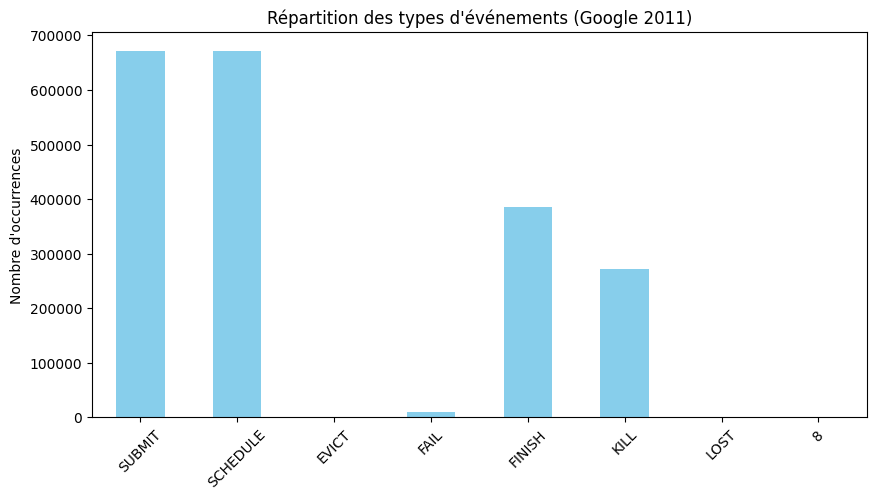

In [42]:
import matplotlib.pyplot as plt

# Compter les types d'événements
counts = df_jobs['event_type'].value_counts().sort_index()

# Remplacer les chiffres par les noms pour le graphique
mapping = {0:'SUBMIT', 1:'SCHEDULE', 2:'EVICT', 3:'FAIL', 4:'FINISH', 5:'KILL', 6:'LOST'}
counts.index = [mapping.get(x, x) for x in counts.index]

# Affichage
plt.figure(figsize=(10, 5))
counts.plot(kind='bar', color='skyblue')
plt.title("Répartition des types d'événements (Google 2011)")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45)
plt.show()

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètre Delta t variable (ex: 5 minutes)
delta_t_us = 5 * 60 * 1000000

# 1. On crée les intervalles
df_jobs['intervalle'] = df_jobs['timestamp'] // delta_t_us

# 2. On compte le nombre de jobs par intervalle
counts = df_jobs.groupby('intervalle').size()

In [44]:
# Fenêtre de calcul (ex: sur les 10 derniers intervalles)
window = 12

stats = pd.DataFrame(counts, columns=['reel'])
stats['moyenne'] = stats['reel'].rolling(window=window, center=True).mean()
stats['min_local'] = stats['reel'].rolling(window=window, center=True).min()
stats['max_local'] = stats['reel'].rolling(window=window, center=True).max()

# Nettoyage des valeurs vides au début/fin
stats = stats.dropna()

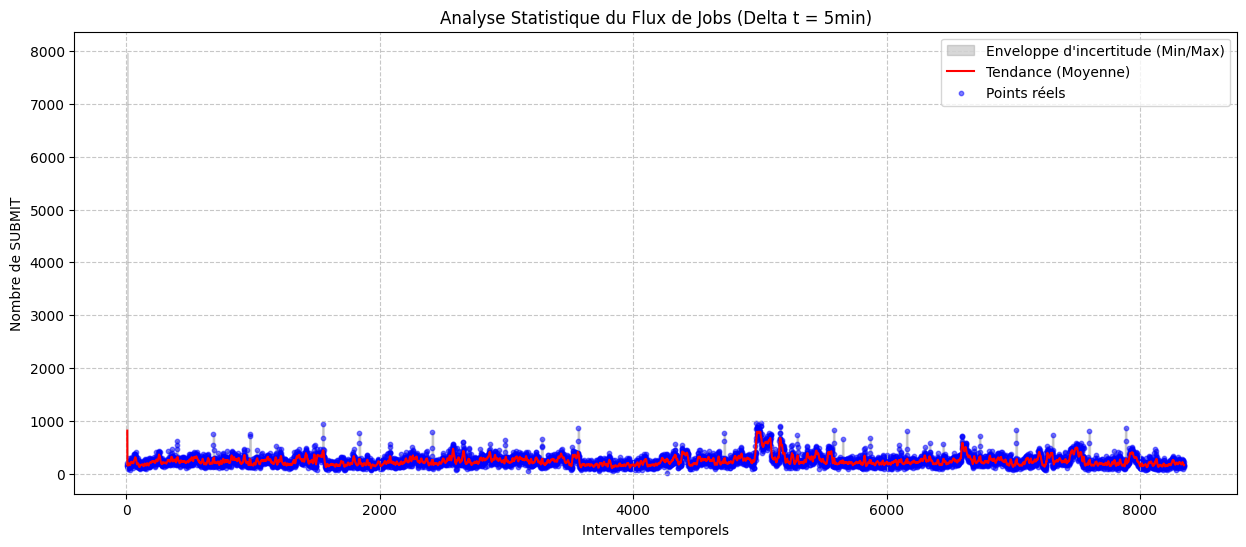

In [45]:
plt.figure(figsize=(15, 6))

# La zone d'incertitude (Les Boîtes min/max)
plt.fill_between(stats.index, stats['min_local'], stats['max_local'],
                 color='gray', alpha=0.3, label='Enveloppe d\'incertitude (Min/Max)')

# La tendance réelle
plt.plot(stats.index, stats['moyenne'], color='red', label='Tendance (Moyenne)')

# Les données brutes
plt.scatter(stats.index, stats['reel'], color='blue', s=10, alpha=0.5, label='Points réels')

plt.title(f"Analyse Statistique du Flux de Jobs (Delta t = 5min)")
plt.xlabel("Intervalles temporels")
plt.ylabel("Nombre de SUBMIT")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()